<a href="https://colab.research.google.com/github/marcelogarret/projeto_mestrado/blob/main/LSTM_garret_JAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install --upgrade pip
%pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html optax flax

  Using cached pip-24.2-py3-none-any.whl.metadata (3.6 kB)
Using cached pip-24.2-py3-none-any.whl (1.8 MB)
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.1/88.1 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.7/780.7 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.2/84.2 MB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.9/378.9 MB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
from jax import random, grad, vmap, jit, value_and_grad
import flax.linen as nn
from flax.training.train_state import TrainState
import optax
from functools import partial

In [3]:
# Carregar o conjunto de dados
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

13568290/13568290 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
df = pd.read_csv(csv_path)
df

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420546,31.12.2016 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
420547,31.12.2016 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
420548,31.12.2016 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2
420549,31.12.2016 23:50:00,999.81,-4.23,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,225.8


In [5]:
df.shape

(420551, 15)

In [6]:
df = df[5::6]

In [7]:
df[:6]

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,01.01.2009 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0
35,01.01.2009 06:00:00,997.71,-9.67,263.66,-10.62,92.7,2.93,2.71,0.21,1.69,2.72,1317.71,0.05,0.50,146.0


In [8]:
df.shape

(70091, 15)

In [9]:
df.index = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S')
df.tail()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,,
2016-12-31 19:10:00,31.12.2016 19:10:00,1002.18,-0.98,272.01,-5.36,72.00,5.69,4.09,1.59,2.54,4.08,1280.70,0.87,1.36,190.6
2016-12-31 20:10:00,31.12.2016 20:10:00,1001.40,-1.40,271.66,-6.84,66.29,5.51,3.65,1.86,2.27,3.65,1281.87,1.02,1.92,225.4
2016-12-31 21:10:00,31.12.2016 21:10:00,1001.19,-2.75,270.32,-6.90,72.90,4.99,3.64,1.35,2.26,3.63,1288.02,0.71,1.56,158.7
2016-12-31 22:10:00,31.12.2016 22:10:00,1000.65,-2.89,270.22,-7.15,72.30,4.93,3.57,1.37,2.22,3.57,1288.03,0.35,0.68,216.7
2016-12-31 23:10:00,31.12.2016 23:10:00,1000.11,-3.93,269.23,-8.09,72.60,4.56,3.31,1.25,2.06,3.31,1292.41,0.56,1.00,202.6


<Axes: xlabel='Date Time'>

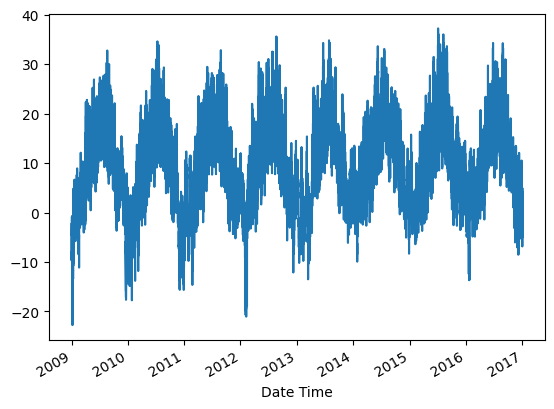

In [10]:
temp = df['T (degC)']
temp.plot()

In [11]:
def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [12]:
WINDOW_SIZE = 5
X, y = df_to_X_y(temp, WINDOW_SIZE)
X.shape, y.shape

((70086, 5, 1), (70086,))

In [13]:
X[0, :, :], y[0]

(array([[-8.05],
        [-8.88],
        [-8.81],
        [-9.05],
        [-9.63]]),
 -9.67)

In [14]:
X_train, y_train = X[:60000], y[:60000]
X_val, y_val = X[60000:65000], y[60000:65000]
X_test, y_test = X[65000:], y[65000:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((60000, 5, 1), (60000,), (5000, 5, 1), (5000,), (5086, 5, 1), (5086,))

In [15]:
# Converter dados para jax.numpy
X_train = jnp.array(X_train)
y_train = jnp.array(y_train)
X_val = jnp.array(X_val)
y_val = jnp.array(y_val)
X_test = jnp.array(X_test)
y_test = jnp.array(y_test)

In [16]:
X_train[0], y_train[0]

(Array([[-8.05],
        [-8.88],
        [-8.81],
        [-9.05],
        [-9.63]], dtype=float32),
 Array(-9.67, dtype=float32))

In [17]:
# Definir a rede LSTM usando Flax
class LSTM(nn.Module):
    @nn.compact
    def __call__(self, x):
        input_shape = x[0].shape
        lstm = nn.OptimizedLSTMCell(64)
        carry = lstm.initialize_carry(jax.random.PRNGKey(0), input_shape)
        for i in range(x.shape[0]):
          if i < (x.shape[0] - 1):
            carry, _ = lstm(carry, x[i])
          else:
            _, x = lstm(carry, x[i])
        x = nn.Dense(8)(x)
        x = nn.relu(x)
        x = nn.Dense(1)(x)
        return x

# Initialize the random key
rng_key = random.PRNGKey(42)

class LSTMnet(LSTM):
    def setup(self):
        super().setup()

# Define the Neural Network
model = LSTMnet()

# Initialize the model parameters
rng_key, init_key = random.split(rng_key, 2)
dummy_input = jnp.zeros(X_train[0].shape)
params = model.init(init_key, dummy_input)

## Define the optimizer using Optax
lr = 0.01
tx = optax.adam(learning_rate=lr)

# Create the training state
state = TrainState.create(
    apply_fn=lambda params_, x_: model.apply(params_, x_)[0],
    # apply_fn=model.apply,
    params=params,
    tx=tx)

In [18]:
# Print the model structure in a fancy way
print(model.tabulate(rng_key, dummy_input))


                                          LSTMnet Summary                                           
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ path               ┃ module            ┃ inputs          ┃ outputs          ┃ params             ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│                    │ LSTMnet           │ float32[5,1]    │ float32[1]       │                    │
├────────────────────┼───────────────────┼─────────────────┼──────────────────┼────────────────────┤
│ OptimizedLSTMCell… │ OptimizedLSTMCell │ - - float32[64] │ - - float32[64]  │                    │
│                    │                   │   - float32[64] │   - float32[64]  │                    │
│                    │                   │ - float32[1]    │ - float32[64]    │                    │
├────────────────────┼───────────────────┼─────────────────┼──────────────────┼───────────

In [19]:
# params['params']

In [20]:
# Solução para 1 exemplo de teste
x_single = jnp.asarray([[0.1], [0.1], [0.1], [0.1], [0.1]])
u = state.apply_fn(params, x_single)
u

Array(-0.04532356, dtype=float32)

In [21]:
u.shape

()

In [22]:
# Solução para todo o dataset de treinamento

u_pred_vmap = vmap(state.apply_fn, (None, 0))(state.params, X_train)
u_pred_vmap

Array([-0.04459291, -0.04176297, -0.0399849 , ..., -0.4972462 ,
       -0.46618813, -0.4390063 ], dtype=float32)

In [23]:
u_pred_vmap.shape

(60000,)

In [24]:
@jit
def train_step(state, batch):
    def loss_fn(params, batch):
        u_pred = vmap(state.apply_fn, (None, 0))(params, batch['x'])
        return jnp.mean(jnp.square(u_pred - batch['u']))
    loss, grads = value_and_grad(loss_fn)(state.params, batch)
    state = state.apply_gradients(grads=grads)
    return loss, state

@jit
def eval_step(state, batch):
    def eval_error(params, batch):
        u_pred = vmap(state.apply_fn, (None, 0))(params, batch['x'])
        # return jnp.linalg.norm(x=(u_pred - batch['u']), ord=2) / jnp.linalg.norm(x=batch['u'], ord=2)
        return jnp.mean(jnp.square(u_pred - batch['u']))
    return eval_error(state.params, batch)

In [25]:
train_batch = {'x': X_train, 'u': y_train}
eval_batch = {'x': X_val, 'u': y_val}

In [26]:
loss_log = []
epoch_log = []
error_log = []

for epoch in range(100):
  loss, state = train_step(state, train_batch)
  epoch_log.append(epoch)
  loss_log.append(loss)
  eval_error = eval_step(state, eval_batch)
  error_log.append(eval_error)
  print(f"Epoch: {epoch} -- Loss: {loss} -- Error: {eval_error}")

Epoch: 0 -- Loss: 169.20196533203125 -- Error: 81.3992919921875
Epoch: 1 -- Loss: 164.80050659179688 -- Error: 78.54159545898438
Epoch: 2 -- Loss: 160.8477783203125 -- Error: 75.90798950195312
Epoch: 3 -- Loss: 157.0643310546875 -- Error: 74.79833221435547
Epoch: 4 -- Loss: 155.38587951660156 -- Error: 73.68486022949219
Epoch: 5 -- Loss: 153.6441650390625 -- Error: 72.43925476074219
Epoch: 6 -- Loss: 151.71298217773438 -- Error: 71.06405639648438
Epoch: 7 -- Loss: 149.60704040527344 -- Error: 69.56596374511719
Epoch: 8 -- Loss: 147.33421325683594 -- Error: 67.95118713378906
Epoch: 9 -- Loss: 144.9070281982422 -- Error: 66.21932220458984
Epoch: 10 -- Loss: 142.33419799804688 -- Error: 64.37300872802734
Epoch: 11 -- Loss: 139.61474609375 -- Error: 62.4133415222168
Epoch: 12 -- Loss: 136.753173828125 -- Error: 60.33014678955078
Epoch: 13 -- Loss: 133.7235107421875 -- Error: 58.109046936035156
Epoch: 14 -- Loss: 130.50384521484375 -- Error: 55.701454162597656
Epoch: 15 -- Loss: 127.0438919

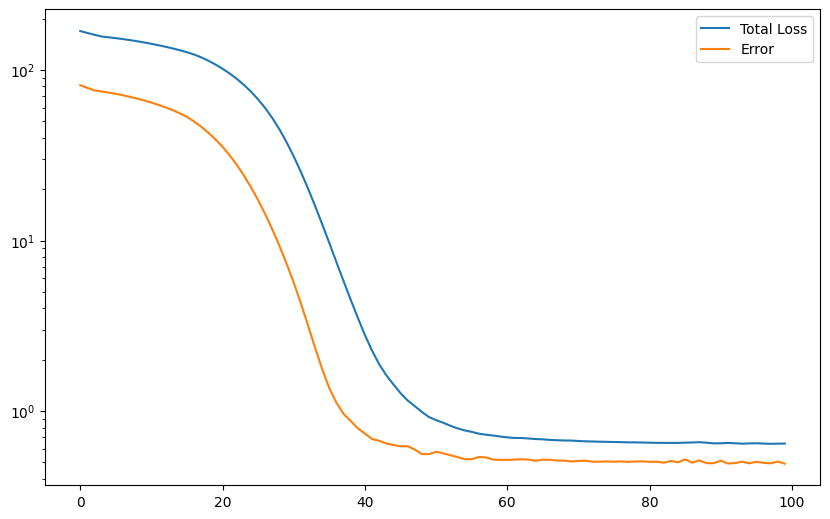

In [27]:
fig, ax = plt.subplots(1,1, figsize=(10,10/1.618))

ax.plot(epoch_log, loss_log, label='Total Loss')
ax.plot(epoch_log, error_log, label='Error')
ax.set_yscale('log')
ax.legend()

In [28]:
test_predictions = vmap(state.apply_fn, (None, 0))(state.params, X_test)
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test})
test_results

,Test Predictions,Actuals
0,14.397428,13.99
1,13.246997,13.46
2,12.895674,12.93
3,12.485644,12.43
4,12.051585,12.17
...,...,...
5081,-1.053057,-0.98
5082,-1.470930,-1.40
5083,-1.458462,-2.75
5084,-2.735385,-2.89


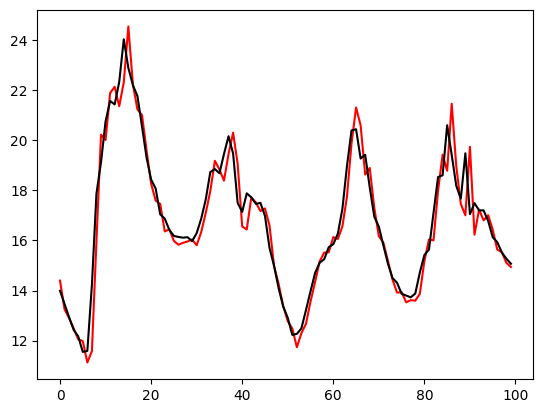

In [29]:
plt.plot(test_results['Test Predictions'][:100], color='red')
plt.plot(test_results['Actuals'][:100], color='black')

In [31]:
from sklearn.metrics import mean_squared_error as mse

def plot_predictions(model, X, y, start=0, end=100):
  predictions = vmap(state.apply_fn, (None, 0))(state.params, X)
  df = pd.DataFrame(data={'Predictions': predictions, 'Actuals':y})
  plt.plot(df['Predictions'][start:end])
  plt.plot(df['Actuals'][start:end])
  return df, mse(predictions, y)

(       Predictions  Actuals
 0        -9.815973    -9.67
 1        -9.626101    -9.17
 2        -8.684981    -8.10
 3        -7.166741    -7.66
 4        -7.122872    -7.04
 ...            ...      ...
 70081    -1.053057    -0.98
 70082    -1.470930    -1.40
 70083    -1.458462    -2.75
 70084    -2.735385    -2.89
 70085    -3.018739    -3.93
 
 [70086 rows x 2 columns],
 0.6304756308405103)

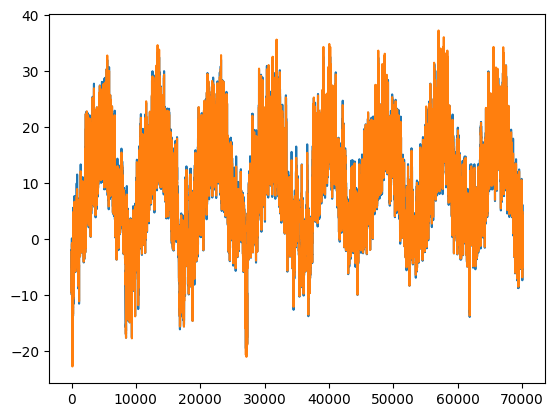

In [32]:
plot_predictions(model, X, y, 0, X.shape[0])

In [34]:
# Prever um passo à frente do último dado observado

# Inicializar o conjunto de dados com os últimos 5 valores
last_data = df['T (degC)'].iloc[-WINDOW_SIZE:].values.reshape((1, WINDOW_SIZE, 1))
print(last_data.flatten())

next_step_prediction = vmap(state.apply_fn, (None, 0))(state.params, last_data)
print(f"Previsão do próximo passo: {next_step_prediction}")

[-0.98 -1.4  -2.75 -2.89 -3.93]
Previsão do próximo passo: [-4.30706]


Previsões para os próximos passos de tempo: [Array([-4.30706], dtype=float32), Array([-4.621051], dtype=float32), Array([-4.7606144], dtype=float32), Array([-4.796251], dtype=float32), Array([-4.7611127], dtype=float32), Array([-4.6770988], dtype=float32), Array([-4.56178], dtype=float32), Array([-4.4271674], dtype=float32), Array([-4.283073], dtype=float32), Array([-4.138062], dtype=float32), Array([-3.9940498], dtype=float32), Array([-3.8460286], dtype=float32), Array([-3.692692], dtype=float32), Array([-3.5333884], dtype=float32), Array([-3.3682518], dtype=float32), Array([-3.1977558], dtype=float32), Array([-3.0231228], dtype=float32), Array([-2.847345], dtype=float32), Array([-2.676165], dtype=float32), Array([-2.5173757], dtype=float32), Array([-2.3773448], dtype=float32), Array([-2.257296], dtype=float32), Array([-2.1532848], dtype=float32), Array([-2.0592074], dtype=float32), Array([-1.9692959], dtype=float32), Array([-1.8789271], dtype=float32), Array([-1.7846025], dtype=float

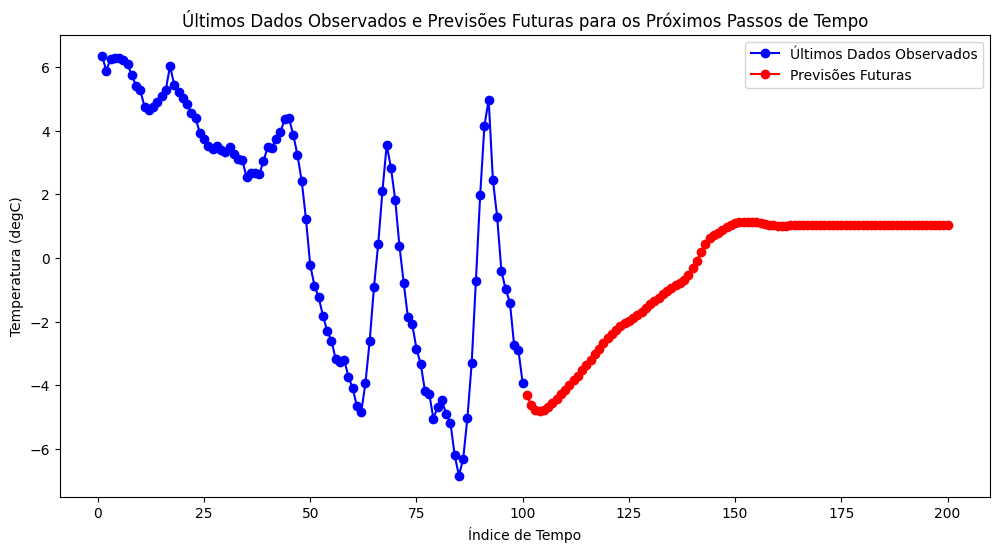

In [38]:
# Obter os últimos pontos de dados observados
n_obs = 100
last_observed = df['T (degC)'].iloc[-n_obs:].values

# Inicializar o conjunto de dados com os últimos 5 valores para previsões
last_data = df['T (degC)'].iloc[-WINDOW_SIZE:].values.reshape((1, WINDOW_SIZE, 1))

# Lista para armazenar as previsões futuras
future_predictions = []

# Quantidade de timesteps de previsão futura
n_timesteps = 100

# Fazer previsões recorrentes para os próximos passos de tempo
for _ in range(n_timesteps):
    # Prever o próximo passo
    next_step_prediction = vmap(state.apply_fn, (None, 0))(state.params, last_data)

    # Adicionar a previsão à lista de previsões futuras
    future_predictions.append(next_step_prediction)

    # Atualizar o conjunto de dados para incluir a nova previsão
    last_data = np.append(last_data[:, 1:, :], next_step_prediction.reshape((1, 1, 1)), axis=1)

# Mostrar as previsões futuras
print("Previsões para os próximos passos de tempo:", future_predictions)

# Plotar os últimos pontos de dados observados e as previsões futuras
plt.figure(figsize=(12, 6))
plt.plot(range(1, n_obs+1), last_observed, marker='o', linestyle='-', color='b', label='Últimos Dados Observados')
plt.plot(range(n_obs+1, n_obs+1+n_timesteps), future_predictions, marker='o', linestyle='-', color='r', label='Previsões Futuras')
plt.xlabel('Índice de Tempo')
plt.ylabel('Temperatura (degC)')
plt.title('Últimos Dados Observados e Previsões Futuras para os Próximos Passos de Tempo')
plt.legend()
plt.show()